**Image classification using CNN and Transfe**r **Learning**

In [1]:
! pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: poojakaware
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset


**Importing Libraries**

In [3]:
!pip install opencv-python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import os
import keras
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

In [4]:
path_of_dataset = '/content/rice-image-dataset/Rice_Image_Dataset'

In [5]:
images =[]
labels =[]

for subfolder in os.listdir(path_of_dataset):
    path_of_subfolder = os.path.join(path_of_dataset,subfolder)
    if not os.path.isdir(path_of_subfolder):
        continue
    for file_of_image in os.listdir(path_of_subfolder):
        image_path=os.path.join(path_of_subfolder,file_of_image)
        images.append(image_path)
        labels.append(subfolder)

In [6]:
data = pd.DataFrame({'image':images,'label':labels})
data.head()

,image,label
0,/content/rice-image-dataset/Rice_Image_Dataset...,Jasmine
1,/content/rice-image-dataset/Rice_Image_Dataset...,Jasmine
2,/content/rice-image-dataset/Rice_Image_Dataset...,Jasmine
3,/content/rice-image-dataset/Rice_Image_Dataset...,Jasmine
4,/content/rice-image-dataset/Rice_Image_Dataset...,Jasmine


In [7]:
class_names = data['label'].unique().tolist()
class_names

['Jasmine', 'Arborio', 'Karacadag', 'Ipsala', 'Basmati']

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   75000 non-null  object
 1   label   75000 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [9]:
df_label=data['label'].value_counts().to_frame().reset_index()
df_label

,label,count
0,Jasmine,15000
1,Arborio,15000
2,Karacadag,15000
3,Ipsala,15000
4,Basmati,15000


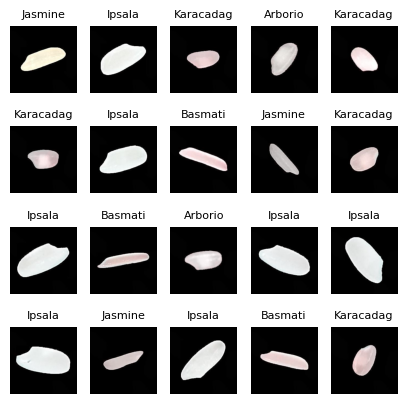

In [10]:
plt.figure(figsize=(5, 5))

for i,n in enumerate(np.random.randint(0,len(data),20)):
    plt.subplot(4,5, i + 1)
    img = cv2.imread(data.image[n])
    plt.imshow(img)
    plt.axis('off')
    plt.title(data.label[n], fontsize=8)
plt.show()

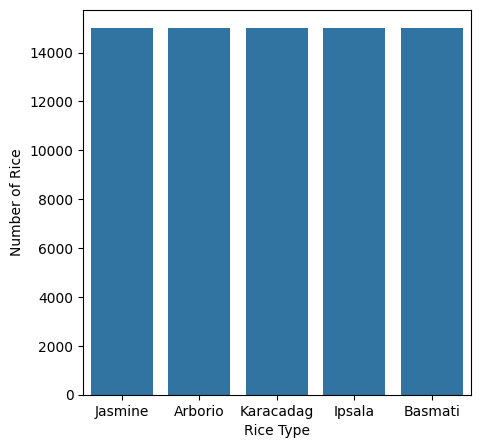

In [11]:
plt.figure(figsize=(5,5))
sns.barplot(data=df_label,x='label',y='count')
plt.xlabel("Rice Type")
plt.ylabel("Number of Rice")
plt.show()

**Splitting Dataset**

In [12]:
x = data['image']
y = data['label']
x_train,x_test1,y_train,y_test1 = train_test_split(x,y,test_size=0.2,shuffle=True,random_state=45)
x_val, x_test, y_val, y_test  = train_test_split(x_test1,y_test1,test_size=0.5,shuffle=True,random_state=45)

In [13]:
print(f'The shape of x_train:{x_train.shape}')
print(f'The shape of x_test:{x_test.shape}')
print(f'The shape of x_val:{x_val.shape}')

The shape of x_train:(60000,)
The shape of x_test:(7500,)
The shape of x_val:(7500,)


In [14]:
print(f'The shape of y_train:{y_train.shape}')
print(f'The shape of y_test:{y_test.shape}')
print(f'The shape of y_val:{y_val.shape}')

The shape of y_train:(60000,)
The shape of y_test:(7500,)
The shape of y_val:(7500,)


In [15]:
train_df = pd.DataFrame({'image':x_train,'label':y_train})
test_df = pd.DataFrame({'image':x_test,'label':y_test})
validation_df = pd.DataFrame({'image':x_val,'label':y_val})

print(f'The shape of train_df:{train_df.shape}')
print(f'The shape of test_df:{test_df.shape}')
print(f'The shape of validation_df:{validation_df.shape}')

The shape of train_df:(60000, 2)
The shape of test_df:(7500, 2)
The shape of validation_df:(7500, 2)


In [16]:
label = LabelEncoder()

y_train = label.fit_transform(y_train)
y_test = label.transform(y_test)
y_val = label.transform(y_val)

In [17]:
Image_size = 60
input_shape = (60,60,3)
Batch_size=32

In [18]:
img_gen = ImageDataGenerator(rescale=0.1/255,horizontal_flip=True,rotation_range=45,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.1,zoom_range=0.1

                            )

In [19]:
train_gen = img_gen.flow_from_dataframe(train_df,x_col='image',y_col='label',
                                        target_size=(Image_size,Image_size),
                                       batch_size=Batch_size,shuffle=True,class_mode='categorical')

test_gen = img_gen.flow_from_dataframe(test_df,x_col='image',y_col='label',
                                        target_size=(Image_size,Image_size),
                                       batch_size=Batch_size,shuffle=False,class_mode='categorical')

val_gen = img_gen.flow_from_dataframe(validation_df,x_col='image',y_col='label',
                                        target_size=(Image_size,Image_size),
                                       batch_size=Batch_size,shuffle=True,class_mode='categorical')

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = img_gen.flow_from_dataframe(example_df,x_col='image',y_col='label',
                                        target_size=(Image_size,Image_size),
                                       batch_size=Batch_size,shuffle=True,class_mode='categorical')

Found 1 validated image filenames belonging to 1 classes.


#CNN **Model**

In [22]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(64,(3,3),activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(Dense(5,activation='softmax'))


cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 58, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,384,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,404,613 (5.36 MB)

 Trainable params: 1,404,613 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
earlystop = EarlyStopping(patience=3)
reduce_learning_rate = ReduceLROnPlateau(monitor="val_accuracy",
                                         patience=2, verbose=1,
                                         factor=0.5,  min_lr=0.00001)

callbacks = [earlystop,reduce_learning_rate]

In [25]:
epochs1 = 5
history1 = cnn_model.fit(train_gen, epochs=epochs1, validation_data=val_gen, callbacks=callbacks) # Changed fit_generator to fit

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 133s 69ms/step - accuracy: 0.7171 - loss: 0.6708 - val_accuracy: 0.8801 - val_loss: 0.2734 - learning_rate: 0.0010
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 125s 66ms/step - accuracy: 0.9158 - loss: 0.2126 - val_accuracy: 0.9524 - val_loss: 0.1353 - learning_rate: 0.0010
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 123s 65ms/step - accuracy: 0.9552 - loss: 0.1190 - val_accuracy: 0.9641 - val_loss: 0.1037 - learning_rate: 0.0010
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 126s 67ms/step - accuracy: 0.9618 - loss: 0.1056 - val_accuracy: 0.9633 - val_loss: 0.1024 - learning_rate: 0.0010
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 124s 66ms/step - accuracy: 0.9716 - loss: 0.0793 - val_accuracy: 0.9825 - val_loss: 0.0506 - learning_rate: 0.0010


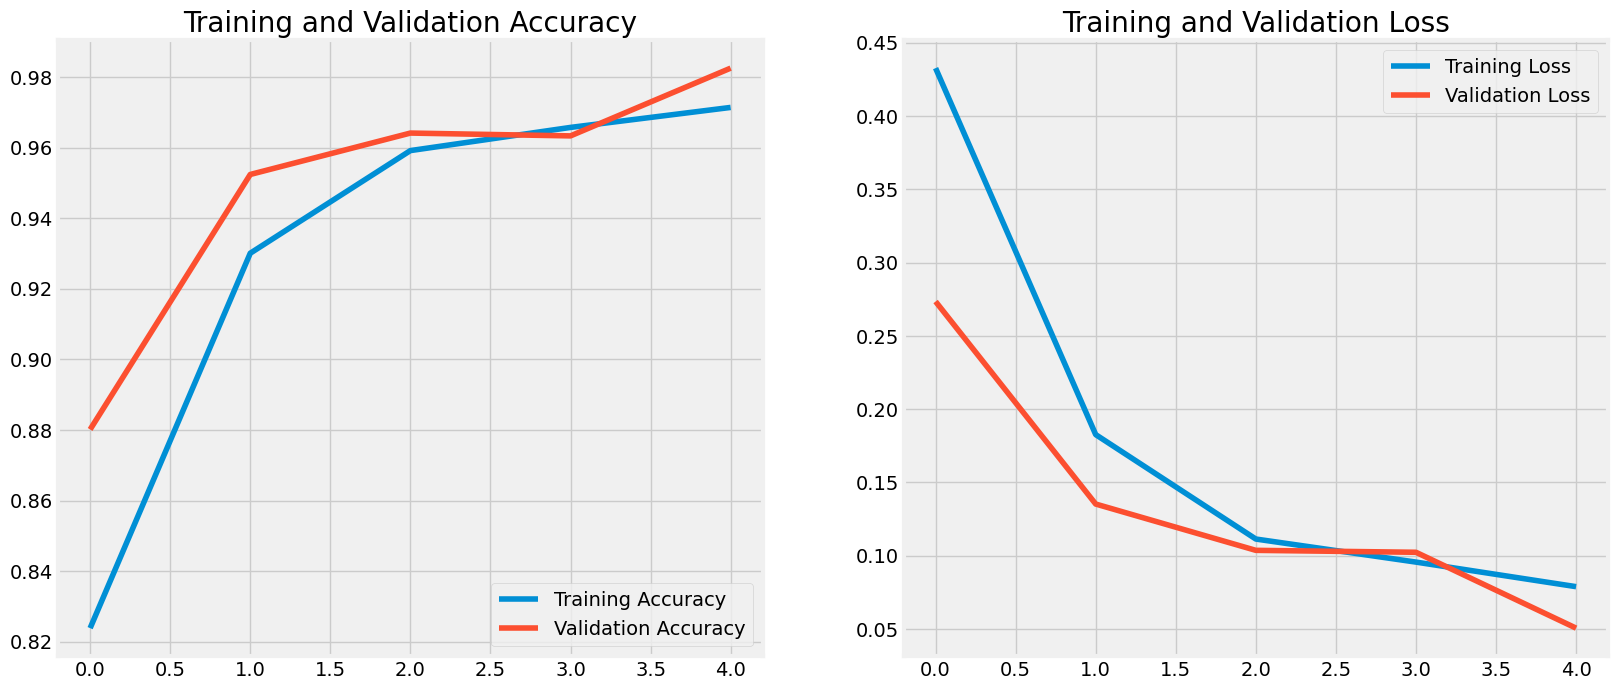

In [28]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs1)

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
test_loss,test_acc = cnn_model.evaluate(test_gen)
print(f'test loss is : {test_loss}')
print(f'test accuracy is : {test_acc}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.9856 - loss: 0.0491
test loss is : 0.05332956463098526
test accuracy is : 0.9830666780471802


In [30]:
predictions = cnn_model.predict(test_gen)
y_pred = np.argmax(predictions,axis=1)
y_test =test_gen.classes
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

df = pd.DataFrame({'Actual':y_test,'Prediction':y_pred})
df

235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step


,Actual,Prediction
0,0,0
1,3,3
2,2,2
3,3,3
4,3,3
...,...,...
7495,3,3
7496,3,3
7497,3,3
7498,0,0


In [33]:
classificationReport = classification_report(y_test,y_pred)
print(f'Classification Report : {classificationReport}')

Classification Report :               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1541
           1       0.99      0.98      0.98      1442
           2       1.00      1.00      1.00      1519
           3       0.97      0.98      0.97      1497
           4       0.97      0.99      0.98      1501

    accuracy                           0.98      7500
   macro avg       0.98      0.98      0.98      7500
weighted avg       0.98      0.98      0.98      7500



In [34]:
cnn_model.save("cnn_model.h5")

In [35]:
from tensorflow.keras.models import load_model


loaded_model = load_model('cnn_model.h5')

#VGG16 **Model**

In [36]:
model_VGG16 =tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(60,60,3),
    weights='imagenet'
)
model_VGG16.trainable = False
input_layer = tf.keras.layers.Input(shape=(60,60,3))
x = model_VGG16(input_layer,training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(5,activation='softmax')(x)

model_VGG16 = tf.keras.Model(inputs=[input_layer],outputs=[output])
model_VGG16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 60, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,245,125 (58.16 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [37]:
earlystop = EarlyStopping(patience=3)
reduce_learning_rate = ReduceLROnPlateau(monitor="val_accuracy",
                                         patience=2, verbose=1,
                                         factor=0.5,  min_lr=0.00001)

callbacks = [earlystop,reduce_learning_rate]
model_VGG16.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
epochs2 = 10
history2 = model_VGG16.fit(train_gen,epochs=epochs2,validation_data=val_gen,callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_104']
Received: inputs=Tensor(shape=(None, 60, 60, 3))
  warnings.warn(msg)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 147s 76ms/step - accuracy: 0.7744 - loss: 0.5557 - val_accuracy: 0.8900 - val_loss: 0.2742 - learning_rate: 0.0010
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 75ms/step - accuracy: 0.8842 - loss: 0.2904 - val_accuracy: 0.8999 - val_loss: 0.2432 - learning_rate: 0.0010
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 142s 76ms/step - accuracy: 0.8915 - loss: 0.2687 - val_accuracy: 0.9083 - val_loss: 0.2273 - learning_rate: 0.0010
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 138s 74ms/step - accuracy: 0.9002 - loss: 0.2510 - val_accuracy: 0.9064 - val_loss: 0.2342 - learning_rate: 0.0010
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9020 - loss: 0.2451
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 141s 75ms/step - accuracy: 0.9020 - loss: 0.2451 - val_accuracy: 0.9029 - val_loss: 0.2389 - learning_rate: 0.0010
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 139s 74ms/step - accuracy: 0.9

#*Evaluation*

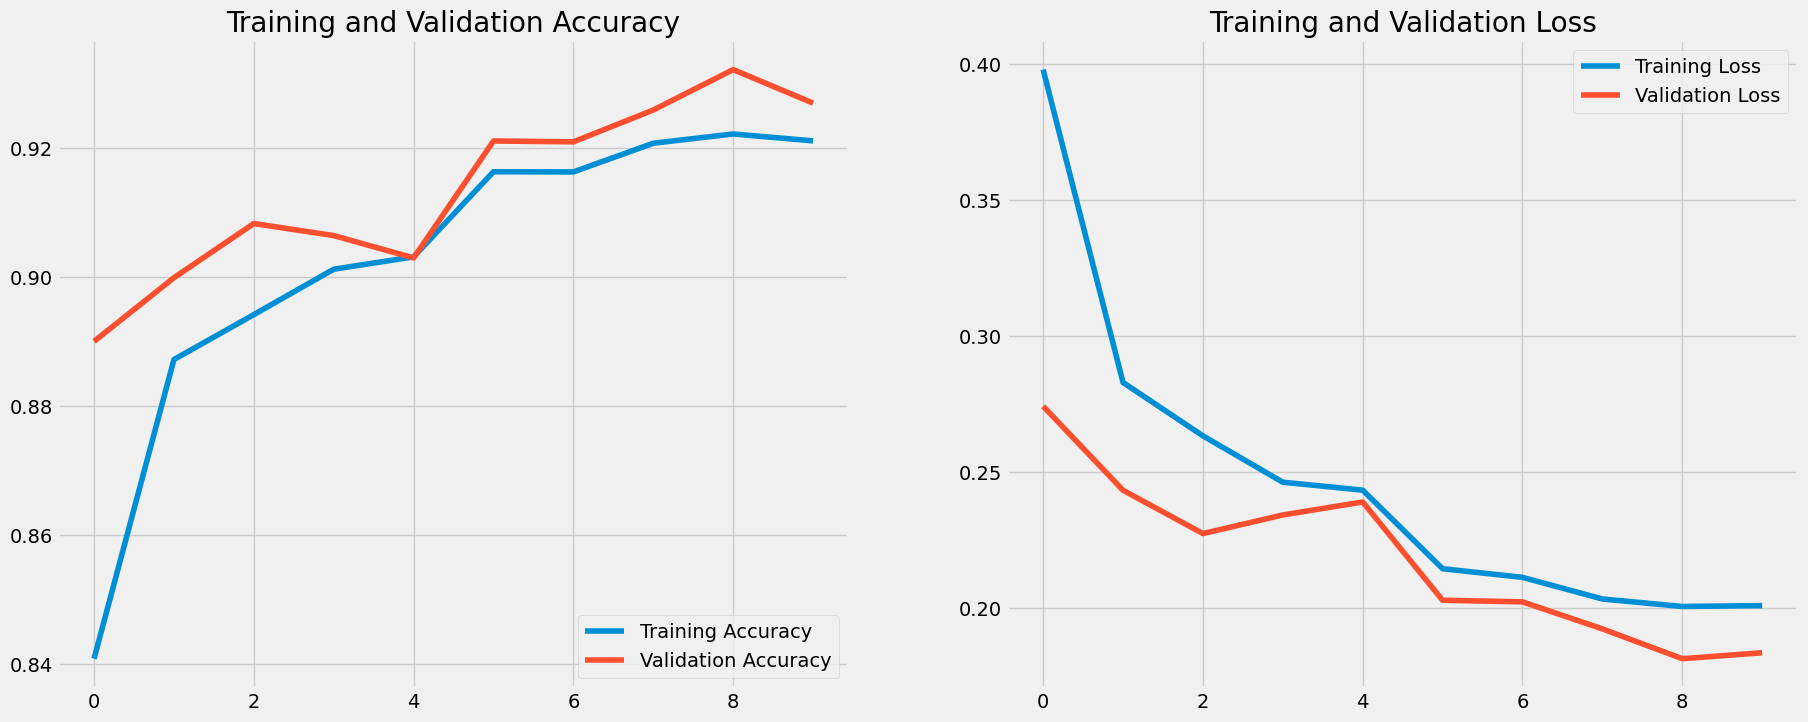

In [39]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs2)

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [40]:
test_loss,test_acc = model_VGG16.evaluate(test_gen)
print(f'test loss is : {test_loss}')
print(f'test accuracy is : {test_acc}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.9287 - loss: 0.1852
test loss is : 0.18513861298561096
test accuracy is : 0.9296000003814697


In [41]:
predictions = model_VGG16.predict(test_gen)
y_pred = np.argmax(predictions,axis=1)
y_test =test_gen.classes
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

df = pd.DataFrame({'Actual':y_test,'Prediction':y_pred})
df

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_104']
Received: inputs=Tensor(shape=(32, 60, 60, 3))
  warnings.warn(msg)


234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_104']
Received: inputs=Tensor(shape=(None, 60, 60, 3))
  warnings.warn(msg)


235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step


,Actual,Prediction
0,0,0
1,3,3
2,2,2
3,3,3
4,3,3
...,...,...
7495,3,3
7496,3,3
7497,3,3
7498,0,0


**classification Report**

In [43]:
classificationReport = classification_report(y_test,y_pred)
print(f'Classification Report : {classificationReport}')

Classification Report :               precision    recall  f1-score   support

           0       0.88      0.90      0.89      1541
           1       0.95      0.92      0.94      1442
           2       0.99      0.99      0.99      1519
           3       0.88      0.94      0.91      1497
           4       0.94      0.88      0.91      1501

    accuracy                           0.93      7500
   macro avg       0.93      0.93      0.93      7500
weighted avg       0.93      0.93      0.93      7500



In [50]:
model_VGG16.save('model_VGG16.h5')